- title: When Regressions Attack
- tags: statistics, week10, bsdetection
- date: 2018-12-3

This lesson is all about what can go wrong in linear regression.  It is organized into two sections: formal mistakes, and substantive mistakes.


- Formal mistakes ("assumptions of regression")
    - heteroskadiscity
    - multicolinnearity
    - data isn't linear
- Substantive mistakes
    - omitted variable bias
    
(simpson's paradox??)
(anscombe's quartet??)


Often, this material is taught in terms of "assumptions of regression."  We say that linear regression assumes certain things about your data/the world that your data represent.  This is kind of indirect language, however. When stats people talk about "assumptions" what they really mean are "things that have to be true or the regression gets the wrong answer."  So we'll just directly talk about the wrong answer and how it can be detected or avoided.

Another way to think about this is as a core part (along with the discussion of p values and power from a couple weeks ago) of your developing a BS detector for statistical claims, offered by scientific studies, expert witnesses, or otherwise.  One way of spewing statistical BS is to report the results of a regression which fails these "assumptions" --- which doesn't actually give you real information.  So in order to keep from being taken in by the BS, you need to know how regressions can go wrong.

(link for bottom: nice clear explanations http://statisticsbyjim.com/regression/ols-linear-regression-assumptions/ ) 

## Linear Regression: read the first word again.

In a lot of ways, the fundamental technical flaw of bad linear regressions is to use it to attempt to represent nonlinear relationships. Remember that what a linear regression does is draws a line (in two dimensions, a plane, or a *hyperplane* (wooooo) or such in more dimensions) that best allows us to predict the dependent variable from the independent variables.  But what if the relationship isn't linear?  

There's a very famous set of data visualizations, called *Anscombe's quartet*, that illustrates this.  It's so important that they actually built it into seaborn, so we can just directly run an example plot from their own documentation and take a look: 

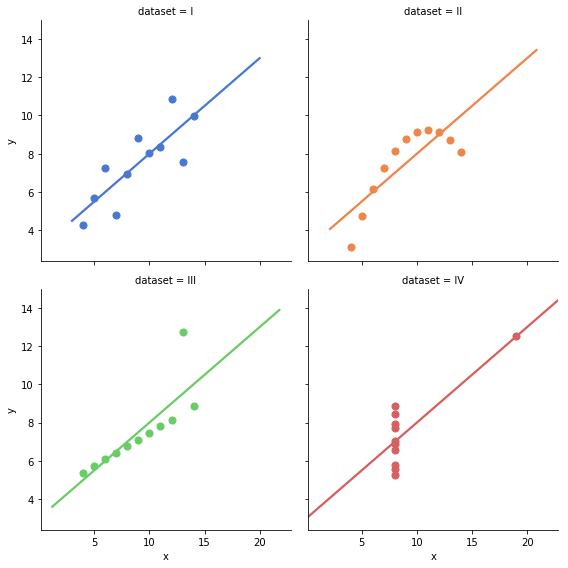

In [1]:
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
import pandas as pd
import numpy as np
%matplotlib inline

df = sns.load_dataset("anscombe")

# Show the results of a linear regression within each dataset
sns.lmplot(x="x", y="y", col="dataset", hue="dataset", data=df,
           col_wrap=2, ci=None, palette="muted", height=4,
           scatter_kws={"s": 50, "alpha": 1})

Anscombe's quartet is really deep (check out [the wikipedia page](https://en.wikipedia.org/wiki/Anscombe%27s_quartet) for details).  What you're looking at is four distinct datasets that have identical means and variances in both x and y, identical correlation coefficients between x and y, and identical linear regression coefficients with identical r-squareds. (!!!!!)  

We're going to keep coming back to this, but for now I just want you to focus on the top row, and compare the top left with the top right. 